In [2]:
import numpy as np
from scipy.stats import jarque_bera
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import seaborn as sns

In [3]:

Data1 = pd.read_excel('G:\\25国赛\\C题\\附件.xlsx', sheet_name='男胎检测数据')


In [5]:
def week_to_day(string):
    normalized = string.replace('W', 'w')
    cleaned = normalized.replace('+', '')

    parts = cleaned.split('w')

    if parts[0].strip():
        week = int(parts[0])
    else:
        return 0

    if len(parts) > 1 and parts[1].strip():
        day = int(parts[1])
    else:
        day = 0

    return week * 7 + day


In [6]:
if '检测孕周' in Data1.columns:
    Data1['检测孕周'] = Data1['检测孕周'].apply(week_to_day)


threshold = Data1['GC含量'].quantile(0.05)
Data1_filtered = Data1[Data1['GC含量'] > threshold]
print(f"原始数据量: {len(Data1)}")
print(f"过滤后数据量: {len(Data1_filtered)}")
print(f"删除了 {len(Data1) - len(Data1_filtered)} 条最小的5%数据")
print("过滤后的数据前5行:")
print(Data1_filtered.head())

原始数据量: 1082
过滤后数据量: 1027
删除了 55 条最小的5%数据
过滤后的数据前5行:
   序号  孕妇代码  年龄     身高    体重                 末次月经 IVF妊娠      检测日期  检测抽血次数  \
0   1  A001  31  160.0  72.0  2023-02-01 00:00:00  自然受孕  20230429       1   
2   3  A001  31  160.0  73.0  2023-02-01 00:00:00  自然受孕  20230625       3   
3   4  A001  31  160.0  74.0  2023-02-01 00:00:00  自然受孕  20230716       4   
4   5  A002  32  149.0  74.0  2023-11-09 00:00:00  自然受孕  20240219       1   
5   6  A002  32  149.0  76.0  2023-11-09 00:00:00  自然受孕  20240310       2   

   检测孕周  ...    Y染色体浓度    X染色体浓度  13号染色体的GC含量  18号染色体的GC含量  21号染色体的GC含量  \
0    83  ...  0.025936  0.038061     0.377069     0.389803     0.399399   
2   141  ...  0.066171  0.075995     0.377449     0.390582     0.399480   
3   160  ...  0.061192  0.052305     0.375613     0.389251     0.397212   
4    97  ...  0.059230  0.059708     0.380260     0.393618     0.404868   
5   117  ...  0.042401  0.040477     0.377387     0.390282     0.399467   

   被过滤掉读段数的比例  染色体的非整倍体  怀孕次数  生产次

In [7]:
def calculate_spearman_matrix(df):
    cols = df.columns
    n = len(cols)

    corr_matrix = pd.DataFrame(np.ones((n, n)), index=cols, columns=cols)
    p_matrix = pd.DataFrame(np.zeros((n, n)), index=cols, columns=cols)

    for i in range(n):
        for j in range(i+1, n):
            corr, p = spearmanr(df[cols[i]], df[cols[j]])
            corr_matrix.loc[cols[i], cols[j]] = corr
            corr_matrix.loc[cols[j], cols[i]] = corr
            p_matrix.loc[cols[i], cols[j]] = p
            p_matrix.loc[cols[j], cols[i]] = p

    return corr_matrix, p_matrix

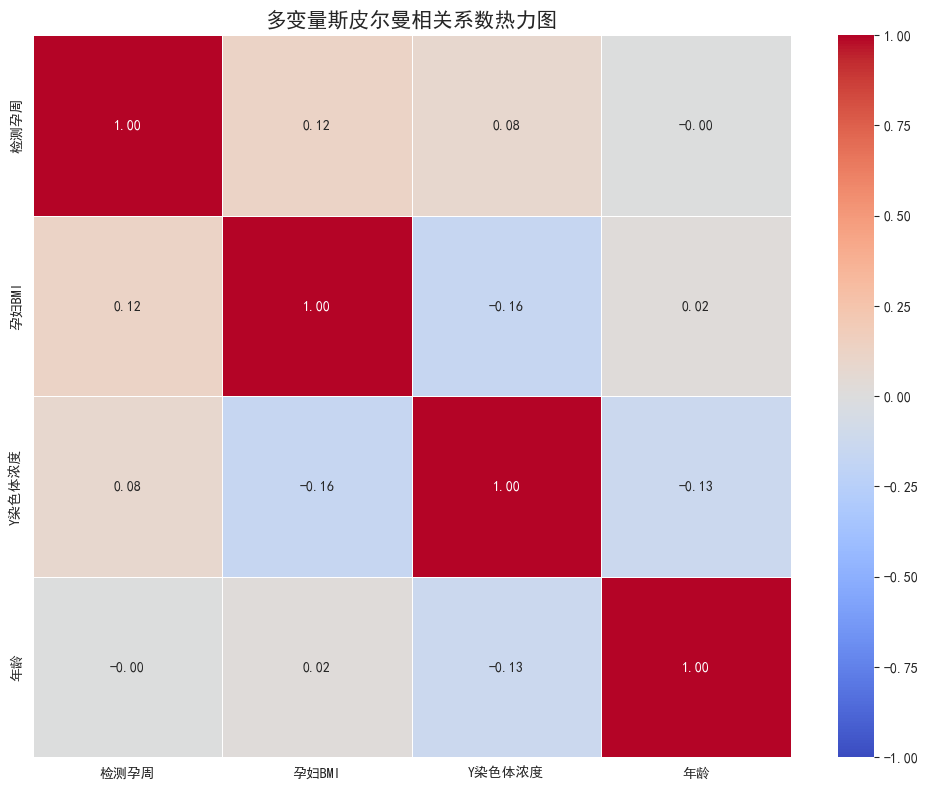


显著相关的变量对（p < 0.05）：
            变量对   相关系数      p值
0    检测孕周-孕妇BMI  0.120  0.0001
1   检测孕周-Y染色体浓度  0.080  0.0108
2  孕妇BMI-Y染色体浓度 -0.162  0.0000
3     Y染色体浓度-年龄 -0.132  0.0000


In [8]:
df = Data1_filtered[['检测孕周','孕妇BMI','Y染色体浓度','年龄']]
corr_matrix, p_matrix = calculate_spearman_matrix(df)

#热力图
plt.figure(figsize=(10, 8))
plt.rcParams["font.family"] = ["SimHei"]
plt.rcParams['axes.unicode_minus'] = False
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap='coolwarm',
    vmin=-1, vmax=1,
    center=0,
    fmt='.2f',
    linewidths=0.5
)
plt.title('多变量斯皮尔曼相关系数热力图', fontsize=15)
plt.tight_layout()
plt.savefig('spearman_correlation_heatmap.png',
            dpi=300,
            bbox_inches='tight')
plt.show()

plt.close()
#筛选出显著相关的变量对（p < 0.05）
significant_pairs = []
cols = df.columns
for i in range(len(cols)):
    for j in range(i+1, len(cols)):
        if p_matrix.iloc[i, j] < 0.05:
            significant_pairs.append({
                '变量对': f"{cols[i]}-{cols[j]}",
                '相关系数': round(corr_matrix.iloc[i, j], 3),
                'p值': round(p_matrix.iloc[i, j], 4)
            })

print("\n显著相关的变量对（p < 0.05）：")
print(pd.DataFrame(significant_pairs))

In [41]:
Data1_filtered.to_excel('Data1_WeekToDay.xlsx', index=False)